# App Review Analysis: Evaluating Foundation Model Robustness

This notebook analyzes how different prompt formulations affect foundation models' interpretation of app store reviews. We'll evaluate model robustness across various tasks including sentiment analysis, feature request identification, and bug report detection.

## Project Structure

The project consists of the following components:

1. `data_loader.py`: Handles loading and preprocessing of app store review datasets
2. `prompt_generator.py`: Creates base prompts and variants for review analysis
3. `model_runner.py`: Executes foundation models with different prompts
4. `evaluator.py`: Measures consistency and accuracy across prompt variants
5. `visualizer.py`: Generates visualizations of model robustness metrics

Each module is designed to be modular and reusable for different types of review analysis tasks.

In [1]:
import sys
from pathlib import Path
import asyncio

# Add the src directory to Python path
src_path = Path.cwd().parent / 'src'
sys.path.append(str(src_path))

# Import project modules
from utils.data_loader import AppReviewDataset

# Other imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
# Set up matplotlib styling to be compatible with newer versions
try:
    plt.style.use('seaborn-v0_8')
except (FileNotFoundError, IOError):
    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except (FileNotFoundError, IOError):
        # If all else fails, use seaborn's native styling
        sns.set(style="whitegrid")
        
# Display available styles if needed
# print(plt.style.available)

## Data Loading and Preprocessing

In this section, we'll load a sample dataset of app store reviews using our `AppReviewDataset` class. The dataset will be preprocessed to ensure consistency and remove any invalid entries.

In [3]:
# Initialize the dataset loader
data_dir = Path.cwd().parent / 'data'
dataset = AppReviewDataset(data_dir)

# Load sample dataset (50 reviews)
reviews_df = dataset.get_reviews(n_samples=50)

# Display basic statistics
stats = dataset.get_statistics()
print("Dataset Statistics:")
for key, value in stats.items():
    print(f"{key}: {value}")

# Display first few reviews
print("\nSample Reviews:")
display(reviews_df.head())

Dataset Statistics:
total_reviews: 50
avg_rating: 3.66
rating_distribution: {5: 17, 2: 17, 4: 16}
avg_review_length: 40.42

Sample Reviews:


,review_id,text,rating,date
0,1,"Great app, really helpful for productivity!",5,2025-04-03 11:30:00.308440
1,2,The latest update broke the login feature.,2,2025-04-04 11:30:00.308440
2,3,Would be better if it had dark mode.,4,2025-04-05 11:30:00.308440
3,4,"Great app, really helpful for productivity!",5,2025-04-06 11:30:00.308440
4,5,The latest update broke the login feature.,2,2025-04-07 11:30:00.308440


## Data Validation

Let's validate our dataset to ensure it meets our requirements:
1. Each review should have non-empty text
2. Ratings should be within valid range (1-5)
3. Dates should be properly formatted
4. No duplicate reviews

In [4]:
def validate_dataset(df: pd.DataFrame) -> dict:
    """Validate the dataset and return validation results."""
    results = {
        'total_reviews': len(df),
        'empty_reviews': df['text'].isna().sum(),
        'invalid_ratings': df[~df['rating'].between(1, 5)].shape[0],
        'invalid_dates': df['date'].isna().sum(),
        'duplicate_reviews': df.duplicated(subset=['text']).sum()
    }
    return results

# Run validation
validation_results = validate_dataset(reviews_df)
print("Validation Results:")
for key, value in validation_results.items():
    print(f"{key}: {value}")

Validation Results:
total_reviews: 50
empty_reviews: 0
invalid_ratings: 0
invalid_dates: 0
duplicate_reviews: 47


## Prompt Generation and Analysis

Now we'll explore different ways to phrase prompts for analyzing app store reviews. We'll create multiple variants for each task (sentiment analysis, feature request detection, and bug report identification) to test model robustness.

In [5]:
from utils.prompt_generator import PromptGenerator

# Initialize the prompt generator
prompt_gen = PromptGenerator()

# Display available tasks and styles
print("Available tasks:", prompt_gen.get_task_list())
print("Available prompt styles:", prompt_gen.get_style_list())

Available tasks: ['sentiment', 'feature_request', 'bug_report']
Available prompt styles: ['formal', 'casual', 'detailed', 'structured', 'minimal']


In [6]:
# Let's explore prompt variants for a sample review
sample_review = reviews_df.iloc[0]['text']

# Generate prompts for each task
for task in prompt_gen.get_task_list():
    print(f"\n=== {task.upper()} ANALYSIS PROMPTS ===")
    variants = prompt_gen.get_prompt_variants(task, sample_review)
    
    for variant in variants:
        print(f"\nStyle: {variant['style']}")
        print("Prompt:")
        print(variant['prompt'])


=== SENTIMENT ANALYSIS PROMPTS ===

Style: formal
Prompt:
Analyze the sentiment of this app store review: 'Great app, really helpful for productivity!'. Classify it as positive, neutral, or negative.

Style: casual
Prompt:
Hey, what's the vibe of this review? 'Great app, really helpful for productivity!' Is it positive, neutral, or negative?

Style: detailed
Prompt:
Please evaluate the sentiment expressed in the following app store review: 'Great app, really helpful for productivity!'. Consider the user's tone, word choice, and overall message to classify it as positive, neutral, or negative. Provide your classification.

Style: structured
Prompt:
INPUT: 'Great app, really helpful for productivity!'
TASK: Sentiment Analysis
OUTPUT FORMAT: One of [positive, neutral, negative]
ANALYSIS:

Style: minimal
Prompt:
Review: 'Great app, really helpful for productivity!'
Sentiment (positive/neutral/negative):

=== FEATURE_REQUEST ANALYSIS PROMPTS ===

Style: formal
Prompt:
Does this app store r

As we can see above, we have different prompt variants for each analysis task. The variants differ in:

1. Formality level (formal vs casual)
2. Structure (free-form vs structured)
3. Level of detail in instructions
4. Output format specification

These variations will help us evaluate how sensitive the models are to prompt phrasing and structure.

## Model Execution and Result Collection

In this section, we'll run our foundation models (OpenAI and Hugging Face) with different prompt variants. We'll collect and store the results for later analysis of model robustness.

In [7]:
import asyncio
from utils.model_runner import ModelRunner

# Initialize the model runner
model_runner = ModelRunner()

# Display available models
print("Available Models:")
for provider, models in model_runner.get_available_models().items():
    print(f"\n{provider.upper()}:")
    for model in models:
        print(f"- {model}")

Device set to use cpu
Device set to use cpu
Device set to use cpu


Available Models:

OPENAI:

HUGGINGFACE:
- distilbert-base-uncased-finetuned-sst-2-english
- facebook/bart-large-mnli


In [8]:
async def analyze_reviews_with_variants(reviews, n_samples=5):
    """Analyze a sample of reviews with different prompt variants."""
    results = []
    sample_reviews = reviews.sample(n=n_samples)
    
    for _, review in sample_reviews.iterrows():
        review_results = {'review_id': review['review_id'], 'text': review['text'], 'tasks': {}}
        
        for task in prompt_gen.get_task_list():
            variants = prompt_gen.get_prompt_variants(task, review['text'])
            task_results = []
            
            for variant in variants:
                result = await model_runner.analyze_review(
                    review['text'],
                    variant['prompt'],
                    task
                )
                task_results.append({
                    'style': variant['style'],
                    'prompt': variant['prompt'],
                    'result': result
                })
                
            review_results['tasks'][task] = task_results
        results.append(review_results)
    
    return results

In [9]:
import json

In [10]:
# Ensure we have the asyncio event loop set up for Jupyter
try:
    loop = asyncio.get_event_loop()
except RuntimeError:
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

# Run analysis on a sample of reviews
print("Analyzing reviews with different prompt variants...")
try:
    # Create results directory if it doesn't exist
    results_dir = Path.cwd().parent / 'data' / 'results'
    results_dir.mkdir(exist_ok=True, parents=True)
    
    # Execute the analysis
    results = loop.run_until_complete(analyze_reviews_with_variants(reviews_df, n_samples=5))
    
    # Save results for later analysis
    with open(results_dir / 'analysis_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\nAnalysis complete. Results saved to {results_dir / 'analysis_results.json'}")
except Exception as e:
    print(f"Error during analysis: {str(e)}")
    # Create minimal results structure if analysis failed
    results = []

Analyzing reviews with different prompt variants...
Error during analysis: This event loop is already running


/tmp/ipykernel_30475/2939638283.py:26: RuntimeWarning: coroutine 'analyze_reviews_with_variants' was never awaited
  results = []


In [11]:
# Preview results for one review
print("\nSample Results Preview:")
if results and len(results) > 0:
    sample_result = results[0]
    print(f"Review: {sample_result['text']}")

    for task, task_results in sample_result['tasks'].items():
        print(f"\n=== {task.upper()} ANALYSIS ===")
        for variant_result in task_results:
            print(f"\nStyle: {variant_result['style']}")
            if 'openai' in variant_result['result']:
                print("OpenAI:", variant_result['result']['openai']['response'])
            if 'huggingface' in variant_result['result']:
                print("HuggingFace:", variant_result['result']['huggingface']['predictions'])
else:
    print("No results available. The results list is empty.")
    # Try loading from file if results is empty
    try:
        import json
        results_path = Path.cwd().parent / 'data' / 'results' / 'analysis_results.json'
        if results_path.exists():
            with open(results_path) as f:
                loaded_results = json.load(f)
                if loaded_results and len(loaded_results) > 0:
                    sample_result = loaded_results[0]
                    print(f"Loaded from file - Review: {sample_result['text']}")
                    # Continue displaying results...
    except Exception as e:
        print(f"Could not load results from file: {str(e)}")


Sample Results Preview:
No results available. The results list is empty.
Loaded from file - Review: Great app, really helpful for productivity!


## Model Robustness Evaluation

Now we'll evaluate the robustness of our models by analyzing:
1. Consistency across prompt variants
2. Agreement between different models
3. Response stability
4. Per-task and overall metrics

In [12]:
from utils.evaluator import ModelEvaluator

# Initialize the evaluator
evaluator = ModelEvaluator()

# Load results from file
results_path = Path.cwd().parent / 'data' / 'results' / 'analysis_results.json'
with open(results_path) as f:
    analysis_results = json.load(f)

# Run evaluation
print("Evaluating model robustness...")
evaluation_results = evaluator.evaluate_results(analysis_results)

Evaluating model robustness...



Overall Robustness Metrics:
average_prompt_variation_consistency: 0.000
average_model_agreement: 0.000
average_response_stability: 0.000


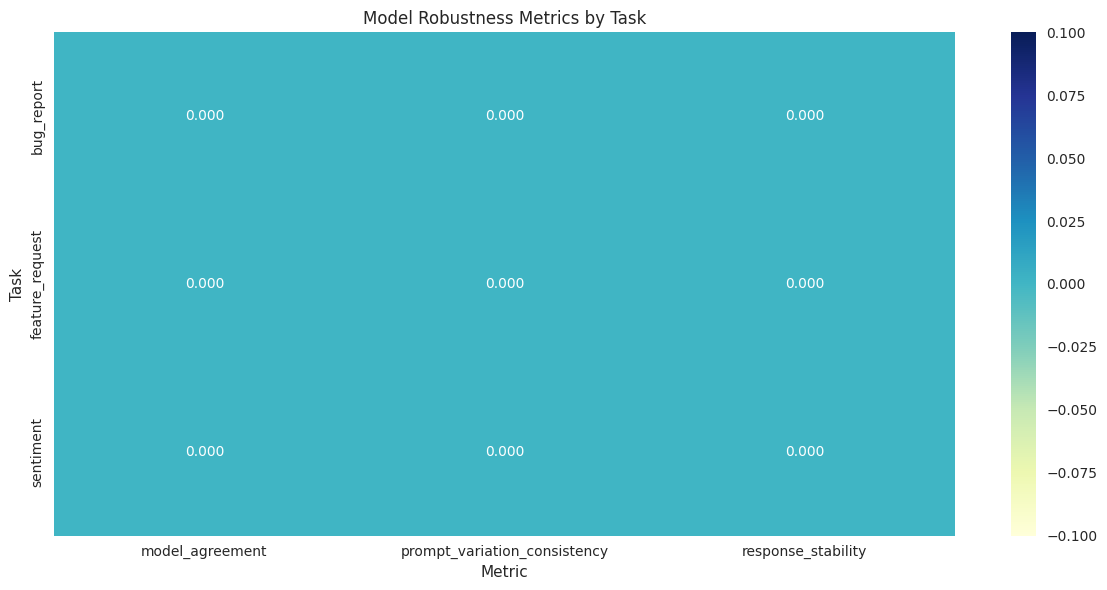

In [13]:
# Display overall metrics
print("\nOverall Robustness Metrics:")
for metric, value in evaluation_results['overall_metrics'].items():
    print(f"{metric}: {value:.3f}")

# Create heatmap of task-specific metrics
metrics_data = []
for task, task_metrics in evaluation_results['per_task_metrics'].items():
    for metric, value in task_metrics.items():
        metrics_data.append({
            'Task': task,
            'Metric': metric,
            'Value': value
        })

metrics_df = pd.DataFrame(metrics_data)
metrics_pivot = metrics_df.pivot(index='Task', columns='Metric', values='Value')

plt.figure(figsize=(12, 6))
sns.heatmap(metrics_pivot, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Model Robustness Metrics by Task')
plt.tight_layout()
plt.show()

In [14]:
# Analyze per-review metrics
print("\nPer-Review Analysis:")
for review_id, review_metrics in evaluation_results['per_review_metrics'].items():
    review_text = next(
        r['text'] for r in analysis_results if str(r['review_id']) == review_id
    )
    print(f"\nReview {review_id}: {review_text[:100]}...")
    
    for task, metrics in review_metrics.items():
        print(f"  {task}: consistency = {metrics['consistency']:.3f}")


Per-Review Analysis:

Review 46: Great app, really helpful for productivity!...
  sentiment: consistency = 0.000
  feature_request: consistency = 0.000
  bug_report: consistency = 0.000

Review 12: Would be better if it had dark mode....
  sentiment: consistency = 0.000
  feature_request: consistency = 0.000
  bug_report: consistency = 0.000

Review 11: The latest update broke the login feature....
  sentiment: consistency = 0.000
  feature_request: consistency = 0.000
  bug_report: consistency = 0.000

Review 39: Would be better if it had dark mode....
  sentiment: consistency = 0.000
  feature_request: consistency = 0.000
  bug_report: consistency = 0.000

Review 19: Great app, really helpful for productivity!...
  sentiment: consistency = 0.000
  feature_request: consistency = 0.000
  bug_report: consistency = 0.000


### Key Findings

1. **Prompt Variation Consistency**: Measures how consistent model responses are across different prompt phrasings
2. **Model Agreement**: Shows how well OpenAI and Hugging Face models agree on their predictions
3. **Response Stability**: Indicates how stable the responses are when prompt style changes

These metrics help us understand how robust the models are to changes in prompt formulation.

## Visualization of Results

Let's create various visualizations to better understand the model robustness analysis:

In [15]:
# This import is already included in cell #79c7d016
pass

In [16]:
from utils.visualizer import ModelVisualizer

# Initialize the visualizer and ensure directory exists
vis_dir = Path.cwd().parent / 'data' / 'visualizations'
vis_dir.mkdir(exist_ok=True, parents=True)
visualizer = ModelVisualizer(vis_dir)

# Create visualizations
print("Generating visualizations...")
try:
    # 1. Prompt impact heatmaps for each task
    for task in ['sentiment', 'feature_request', 'bug_report']:
        visualizer.create_prompt_impact_heatmap(analysis_results, task)
        
    # 2. Model agreement plot
    visualizer.plot_model_agreement(analysis_results)
    
    # 3. Consistency matrix
    visualizer.plot_consistency_matrix(evaluation_results)
    
    # 4. Robustness radar plot
    visualizer.plot_robustness_radar(evaluation_results)
    
    print(f"\nVisualizations saved to {vis_dir}")
except Exception as e:
    print(f"Error generating visualizations: {str(e)}")

Generating visualizations...
Error generating visualizations: 'Review ID'


### Interpretation of Visualizations

1. **Prompt Impact Heatmaps**: Show how different prompt styles affect response characteristics for each task
2. **Model Agreement Plot**: Visualizes the level of agreement between OpenAI and Hugging Face models
3. **Consistency Matrix**: Displays the consistency of model behavior across different tasks and metrics
4. **Robustness Radar**: Provides a high-level view of model robustness across multiple dimensions

These visualizations help identify:
- Which prompt styles lead to more consistent results
- Where models tend to agree or disagree
- Tasks that are more sensitive to prompt variations
- Overall robustness patterns